###    Create a multi input  Neural Network Based on the functional API of Keras Tensor FLow

* Input 1 : dims = 5 [load, Bt_Prod, Ht_Prod] where Ht_Prod = [P0010, P0018,P0100]
* Input 2 : dims = 4 [hourly_cycle, daily_cycle, weekly_cycle, yearly_cycle]
* Input 3 : dims = 1 [Boolean var (0,1) indicating wether voltage rise occurs durings past periods ]
* Input 4 : dims = 1 [float var indicating the value of voltage rize that occurs durings past periods ]

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pydot

In [2]:
from sklearn.preprocessing import OneHotEncoder

#### Define Inputs i.e. total features for each inputs 

In [3]:
n1 =  5  ;       # [load, Bt_Prod, Ht_Prod] where Ht_Prod = [P0010, P0018,P0100]
# n2 = 12+12+7+6   # 12 months || 6h-18h ==> 12 H || 7 days in a week || 6 periods (1:0mn ,2:10mn ... 6:50mn)
n2 = 4   # 12 months || 6h-18h ==> 12 H || 7 days in a week || 6 periods (1:0mn ,2:10mn ... 6:50mn)

n3 = 1

n4 = 1


actv_func ='relu'
in1_ts = 60      # Number of time steps per batch for the input 1
in2_ts = 18      # Number of time steps per batch for the second input
in3_ts = 18     # 
in4_ts = 18


# Define model output_features
n_out_mod1 = n1 # The model must to predict all the input n1 

# batchSizes = 32

in1 = keras.Input(shape=(in1_ts,n1), name='Numeric')  # Input 1 | For the input intanciate only the feature dimension. i.e. create a tensor as 
                                  # in1.shape = [None, n1]
# Input 2 
in2 = keras.Input(shape=(in2_ts, n2), name='cyclingdata')   # Input 2 


in3 = keras.Input(shape=(in2_ts, n3), name='BinaryVoltageRise')   # Input 23

in4 = keras.Input(shape=(in4_ts, n4), name='NumericVoltageRise')

#### Define number of cell on different layers

In [4]:
neur_lstm_layer1 = 40
neur_lstm_layer2 = 40
neur_lstm_layer3 = 30

#### Input 1 

##### Create hidden layers

In [5]:
in1_layer1    = layers.LSTM(128, activation=actv_func) # Create the first layer of model 1
# in1_layer2    = layers.LSTM(neur_lstm_layer2, activation=actv_func, )                        # Create the second layer of model 1
# in1_layer3    = layers.LSTM(neur_lstm_layer3, activation=actv_func)

##### Link input 1 to hidden layer 1
Since the layer is an LSTM,  one needs to reshape the input such that its dimension in [x,y,z] so they can correspond to a LSTM's. 
- x ==> batch size, 
- y ==> nber_time_step_per batch ,
- z ==> number of feature

In [6]:
in1_layer1_out = in1_layer1(in1)        
# in1_layer1_out = in1_layer1(tf.reshape(in1, (-1, in1_ts, n1 )))        

# Since we are returning the sequence of the previous lstm layer it can be directly link to the second layer
# in1_layer2_out = in1_layer2(in1_layer1_out)  # Link output of hiddend layer 1 to to hidden layer 2
# in1_layer3_out = in1_layer3(in1_layer2_out)

#### Input 2

##### Create hidden layers

In [7]:
in2_layer1 = layers.LSTM(64,activation=actv_func)
# in2_layer2 = layers.LSTM(neur_lstm_layer1, activation=actv_func, )
# in2_layer3 = layers.LSTM(neur_lstm_layer1, activation=actv_func)

##### Link input 2 to hidden layer 1
**<span style='color:red'> SAME PROCESS AS WITH INPUT 1 </span>**

In [8]:
# in2_layer1_out = in2_layer1(tf.reshape(in2, (-1, in2_ts, n2)),)
in2_layer1_out = in2_layer1(in2)
# in2_layer2_out = in2_layer2(in2_layer1_out)
# in2_layer3_out = in2_layer3(in2_layer2_out)

#### Input 3

In [9]:
##### Create hidden layers
in3_layer1 = layers.LSTM(64,activation=actv_func)
# in2_layer2 = layers.LSTM(neur_lstm_layer1, activation=actv_func, )
# in2_layer3 = layers.LSTM(neur_lstm_layer1, activation=actv_func)

# Link input to output
# in2_layer1_out = in2_layer1(tf.reshape(in2, (-1, in2_ts, n2)),)
in3_layer1_out = in3_layer1(in3)
# in2_layer2_out = in2_layer2(in2_layer1_out)
# in2_layer3_out = in2_layer3(in2_layer2_out)

#### Input 4

In [10]:
##### Create hidden layers
in4_layer1 = layers.LSTM(64,activation=actv_func)
# in2_layer2 = layers.LSTM(neur_lstm_layer1, activation=actv_func, )
# in2_layer3 = layers.LSTM(neur_lstm_layer1, activation=actv_func)

# Link input to output
# in2_layer1_out = in2_layer1(tf.reshape(in2, (-1, in2_ts, n2)),)
in4_layer1_out = in4_layer1(in4)
# in2_layer2_out = in2_layer2(in2_layer1_out)
# in2_layer3_out = in2_layer3(in2_layer2_out)

#### Combine layers

In [11]:
# # concatanate output of hidden layer2

comb_main = layers.concatenate([in1_layer1_out, in2_layer1_out]) # numeric var and cycling data 
comb_out2 = layers.concatenate([comb_main, in3_layer1_out])      # 
comb_out3 = layers.concatenate([comb_main, in4_layer1_out])


#### Create an intermediate and the output layer and link them together with 

In [12]:
# create new dense Layer and connect to the concatanation layers
in12_layer_out = layers.Dense(60)(comb_main)
int123_layer_out = layers.Dense(10)(comb_out2)
int124_layer_out = layers.Dense(10)(comb_out3)


out_numPred = layers.Dense(n1, activation='relu', name='NumPred' )(in12_layer_out)
out_vriseBin = layers.Dense(n3, activation='sigmoid', name='binVrisePred')(int123_layer_out)
out_vriseNum = layers.Dense(n4, activation='relu', name='numVrisePred')(int124_layer_out)


#### Create final model 

In [13]:
mixed_model = keras.Model(inputs=[in1,in2, in3, in4], outputs=[out_numPred, out_vriseBin, out_vriseNum])

#### Show model parameters

In [14]:
mixed_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Numeric (InputLayer)           [(None, 60, 5)]      0           []                               
                                                                                                  
 cyclingdata (InputLayer)       [(None, 18, 4)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          68608       ['Numeric[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 64)           17664       ['cyclingdata[0][0]']            
                                                                                              

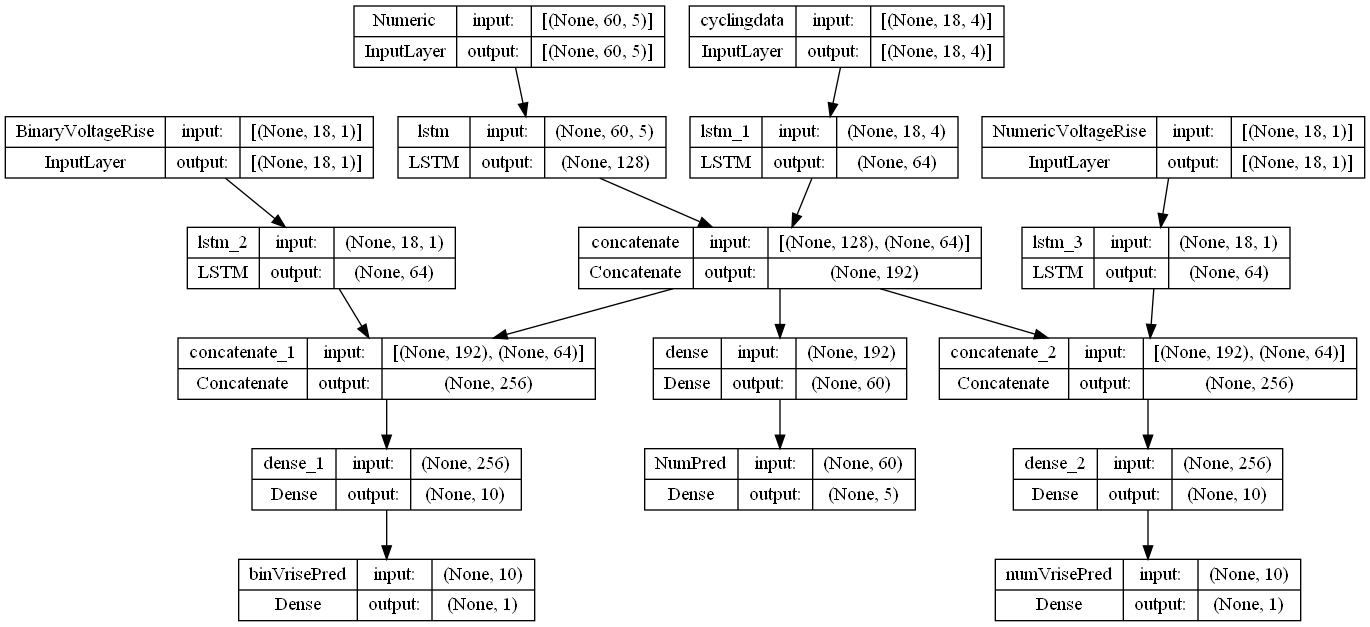

In [18]:
keras.utils.plot_model(mixed_model,show_shapes=True  )

In [17]:
mixed_model.save("pickle_files/RNN/Multi3_Input")

INFO:tensorflow:Assets written to: pickle_files/RNN/Multi3_Input\assets


INFO:tensorflow:Assets written to: pickle_files/RNN/Multi3_Input\assets


In [46]:
mixed_model.input

[<KerasTensor: shape=(None, 72, 5) dtype=float32 (created by layer 'Numeric')>,
 <KerasTensor: shape=(None, 72, 4) dtype=float32 (created by layer 'Categorical')>]

### Reading [# Forecasting: Principles and Practice](https://otexts.com/fpp3/)



#### Getting Started

###### Time Series Data :
Data collected at regular spaced interval over time


###### Cross -sectional data : 
Data collected at asogle point in time

###### Decomposition method's role in time series prediction: 
They are useful for studying the trend and seasonal pattern in a time series

Supposing $ED$ represent the Electricity demand, its <span>Explanatory model </span> 
Helps explain what couses the variation in a variable to predict. , 